### imports

In [185]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf


### direct single-step prediction

#### data setup

In [187]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [241]:
area = "city of london"
monthly_data = utils.load_interpolated_data()


def to_date(seconds):
    start_time = monthly_data["date"][0]
    return np.array([start_time + timedelta(seconds=num) for num in seconds])


area_data = utils.get_area(monthly_data, area)

# X = np.array(area_data["seconds"]).reshape(
#     -1, 1)  # can also add other features like crimes, salary, population, etc
price_ts = np.array(area_data["average_price"]).reshape(-1, 1)

(0.0, 983052.55)

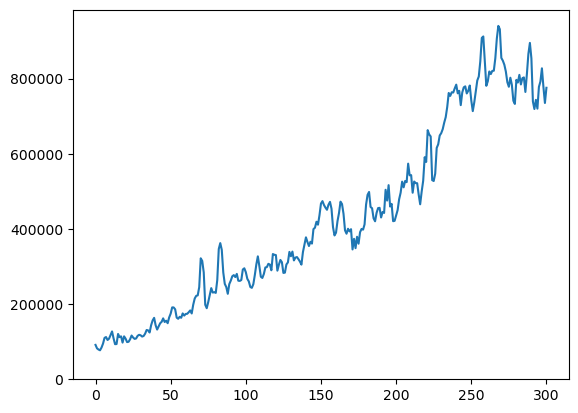

In [245]:
plt.plot(price_ts)
plt.ylim(bottom=0)

In [190]:
# normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
price_ts = scaler.fit_transform(price_ts)

# split train/test data
train, test = train_test_split(price_ts, test_size=0.3, shuffle=False)


In [205]:
# reformat into windows of data
lookback = 12
X_train, y_train = utils.create_windowed_dataset(train, lookback)
X_test, y_test = utils.create_windowed_dataset(test, lookback)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [206]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(197, 12, 1)
(197,)
(78, 12, 1)
(78,)


#### create and train model

In [207]:
def compile_and_fit(model,
                    X_train,
                    y_train,
                    X_test,
                    y_test,
                    epochs=20,
                    patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(X_train,
                        y_train,
                        batch_size=32,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping])
    return history


In [208]:
# batch_size = 1

lstm_model = tf.keras.models.Sequential([
    # Shape [batch size, timesteps, features per timestep] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, input_shape=(lookback, 1), return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [209]:
history = compile_and_fit(lstm_model,
                          X_train,
                          y_train,
                          X_test,
                          y_test,
                          epochs=50,
                          patience=10)


Epoch 1/50
7/7 [==============================] - 3s 135ms/step - loss: 0.0598 - mean_absolute_error: 0.2037 - val_loss: 0.3171 - val_mean_absolute_error: 0.5453
Epoch 2/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0400 - mean_absolute_error: 0.1633 - val_loss: 0.1962 - val_mean_absolute_error: 0.3964
Epoch 3/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0341 - mean_absolute_error: 0.1510 - val_loss: 0.1575 - val_mean_absolute_error: 0.3345
Epoch 4/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0326 - mean_absolute_error: 0.1479 - val_loss: 0.1673 - val_mean_absolute_error: 0.3631
Epoch 5/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0296 - mean_absolute_error: 0.1414 - val_loss: 0.1898 - val_mean_absolute_error: 0.4044
Epoch 6/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0284 - mean_absolute_error: 0.1393 - val_loss: 0.2010 - val_mean_absolute_error: 0.4232
Epoch 7/50
7/7 [=================

#### predictions/evaluation

3/3 [==============================] - 0s 3ms/step


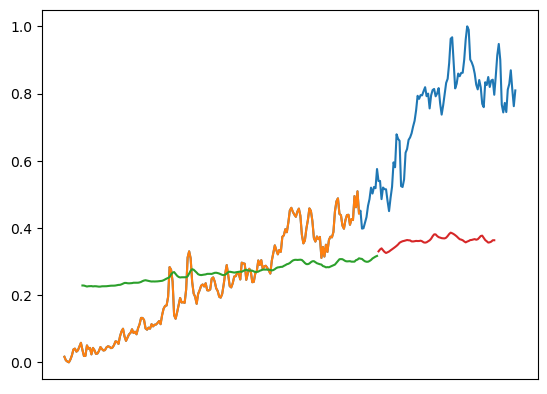

In [213]:
pred_train = lstm_model.predict(X_train)[:, -1]
pred_test = lstm_model.predict(X_test)[:, -1]

# un-scale the predictions
# price_ts = scaler.inverse_transform(price_ts)
# pred_train = scaler.inverse_transform(pred_train)
# pred_test = scaler.inverse_transform(pred_test)

plt.plot(price_ts)
plt.gca().set_xticks([])
plt.plot(X_train[:, 0])
plt.plot(range(lookback, lookback + len(pred_train)), pred_train)
plt.plot(
    range(lookback + len(pred_train),
          lookback + len(pred_train) + len(pred_test)), pred_test)
plt.show()

wow the val loss is actually super bad when u look at the numbers... 

### predicting the diff

#### data

In [347]:
area = "city of london"
monthly_data = utils.load_interpolated_data()


def to_date(seconds):
    start_time = monthly_data["date"][0]
    return np.array([start_time + timedelta(seconds=num) for num in seconds])


area_data = utils.get_area(monthly_data, area)

# X = np.array(area_data["seconds"]).reshape(
#     -1, 1)  # can also add other features like crimes, salary, population, etc
price_d1_ts = np.array(area_data["average_price_d1"]).reshape(-1, 1)

In [348]:
# normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
price_d1_ts = scaler.fit_transform(price_d1_ts)

# split train/test data
train, test = train_test_split(price_d1_ts, test_size=0.3, shuffle=False)


In [349]:
# reformat into windows of data
lookback = 12
X_train, y_train = utils.create_windowed_dataset(train, lookback)
X_test, y_test = utils.create_windowed_dataset(test, lookback)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [350]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(197, 12, 1)
(197, 1)
(78, 12, 1)
(78, 1)


#### create and train model

In [351]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch size, timesteps, features per timestep] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, input_shape=(lookback, 1), return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [352]:
history = compile_and_fit(lstm_model,
                          X_train,
                          y_train,
                          X_test,
                          y_test,
                          epochs=500,
                          patience=10)


Epoch 1/500
7/7 [==============================] - 2s 78ms/step - loss: 0.2750 - mean_absolute_error: 0.5113 - val_loss: 0.2143 - val_mean_absolute_error: 0.4327
Epoch 2/500
7/7 [==============================] - 0s 9ms/step - loss: 0.1651 - mean_absolute_error: 0.3849 - val_loss: 0.1257 - val_mean_absolute_error: 0.3117
Epoch 3/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0869 - mean_absolute_error: 0.2521 - val_loss: 0.0804 - val_mean_absolute_error: 0.2244
Epoch 4/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0600 - mean_absolute_error: 0.1919 - val_loss: 0.0827 - val_mean_absolute_error: 0.2301
Epoch 5/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0597 - mean_absolute_error: 0.1979 - val_loss: 0.0751 - val_mean_absolute_error: 0.2161
Epoch 6/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0515 - mean_absolute_error: 0.1761 - val_loss: 0.0677 - val_mean_absolute_error: 0.2023
Epoch 7/500
7/7 [================

#### predictions/evaluation

3/3 [==============================] - 0s 3ms/step


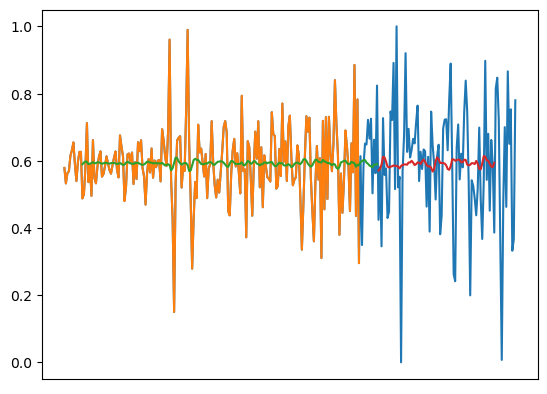

In [353]:
pred_train = lstm_model.predict(X_train)[:, -1]
pred_test = lstm_model.predict(X_test)[:, -1]

# un-scale the predictions
# price_ts = scaler.inverse_transform(price_ts)
# pred_train = scaler.inverse_transform(pred_train)
# pred_test = scaler.inverse_transform(pred_test)

plt.plot(price_d1_ts)
plt.gca().set_xticks([])
plt.plot(X_train[:, 0])
plt.plot(range(lookback, lookback + len(pred_train)), pred_train)
plt.plot(
    range(lookback + len(pred_train),
          lookback + len(pred_train) + len(pred_test)), pred_test)
plt.show()

In [354]:
# un-scale the predictions
price_d1_ts = scaler.inverse_transform(price_d1_ts)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

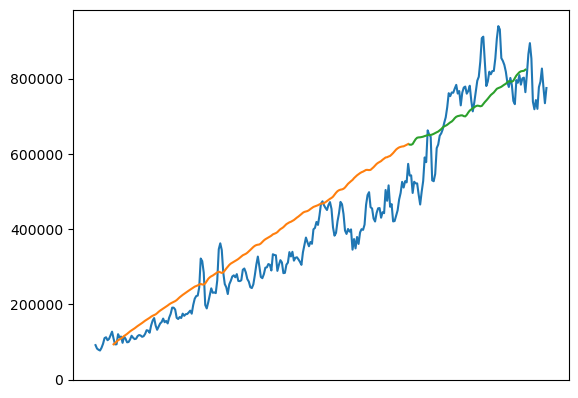

In [355]:
price_d1_ts_cum = np.cumsum(price_d1_ts) + area_data.average_price[0]
pred_train_cum = np.cumsum(pred_train) + area_data.average_price[0]
pred_test_cum = np.cumsum(pred_test) + pred_train_cum[-1]

plt.plot(price_d1_ts_cum)
plt.gca().set_xticks([])
# plt.plot(X_train[:, 0])
plt.plot(range(lookback, lookback + len(pred_train)), pred_train_cum)
plt.plot(
    range(lookback + len(pred_train),
          lookback + len(pred_train) + len(pred_test)), pred_test_cum)
plt.ylim(bottom=0)
plt.show()

wow, when i trained it for 500 epochs (vs 50) it actually collapsed to the mean *MORE* and the results look worse. at first i thought it might be overfitting but the results are quite bad on the train set too. weird.  

hard to assess if this is actually better or not bc this is not autoregressive

### predict diff autoregressively

In [333]:
area = "city of london"
monthly_data = utils.load_interpolated_data()


def to_date(seconds):
    start_time = monthly_data["date"][0]
    return np.array([start_time + timedelta(seconds=num) for num in seconds])


area_data = utils.get_area(monthly_data, area)

# X = np.array(area_data["seconds"]).reshape(
#     -1, 1)  # can also add other features like crimes, salary, population, etc
price_d1_ts = np.array(area_data["average_price_d1"]).reshape(-1, 1)

In [334]:
# normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
price_d1_ts = scaler.fit_transform(price_d1_ts)

# split train/test data
train, test = train_test_split(price_d1_ts, test_size=0.3, shuffle=False)


In [335]:
# reformat into windows of data
lookback = 12
lookforward = 12
X_train, y_train = utils.create_windowed_dataset(train, lookback, lookforward)
X_test, y_test = utils.create_windowed_dataset(test, lookback, lookforward)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [336]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(186, 12, 1)
(186, 12)
(67, 12, 1)
(67, 12)


#### create and train model

In [337]:
class AR_LSTM(tf.keras.Model):
    """ autoregressive LSTM """
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units, input_shape=(lookback, 1), )
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(1)

    # tf.keras.layers.LSTM(32, input_shape=(lookback, 1), return_sequences=True),

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                    training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions


In [338]:
ar_lstm_model = AR_LSTM(units=32, out_steps=12) # 12 month rollout forecast

In [339]:
history = compile_and_fit(ar_lstm_model,
                          X_train,
                          y_train,
                          X_test,
                          y_test,
                          epochs=50,
                          patience=10)


Epoch 1/50
6/6 [==============================] - 3s 109ms/step - loss: 0.3405 - mean_absolute_error: 0.5719 - val_loss: 0.2866 - val_mean_absolute_error: 0.5108
Epoch 2/50
6/6 [==============================] - 0s 12ms/step - loss: 0.2197 - mean_absolute_error: 0.4538 - val_loss: 0.1614 - val_mean_absolute_error: 0.3724
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0966 - mean_absolute_error: 0.2874 - val_loss: 0.0488 - val_mean_absolute_error: 0.1862
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0213 - mean_absolute_error: 0.1141 - val_loss: 0.0508 - val_mean_absolute_error: 0.1749
Epoch 5/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0330 - mean_absolute_error: 0.1483 - val_loss: 0.0370 - val_mean_absolute_error: 0.1447
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0152 - mean_absolute_error: 0.0911 - val_loss: 0.0308 - val_mean_absolute_error: 0.1377
Epoch 7/50
6/6 [=================

#### predictions/evaluation

In [340]:
pred_train = ar_lstm_model.predict(X_train)#[:, -1]
pred_test = ar_lstm_model.predict(X_test)#[:, -1]
pred_train[:, -1].shape

3/3 [==============================] - 0s 3ms/step


(186, 1)

3/3 [==============================] - 0s 3ms/step


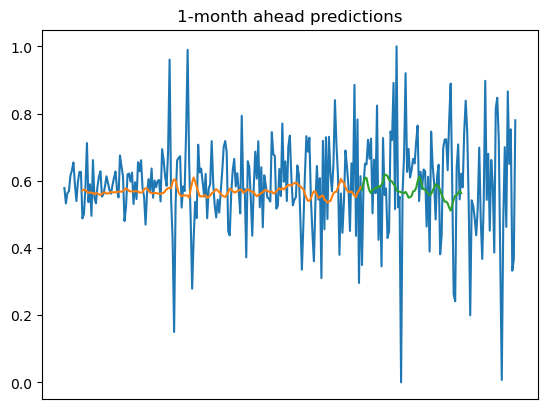

In [341]:
pred_train = ar_lstm_model.predict(X_train)#[:, :, 0]
pred_test = ar_lstm_model.predict(X_test)#[:, :, 0]

plt.plot(price_d1_ts)
plt.gca().set_xticks([])

plt.plot(range(lookback, lookback + len(pred_train)), pred_train[:, 0])
plt.plot(
    range(lookback + len(pred_train),
          lookback + len(pred_train) + len(pred_test)), pred_test[:, 0])
plt.title('1-month ahead predictions')
plt.show()

3/3 [==============================] - 0s 3ms/step


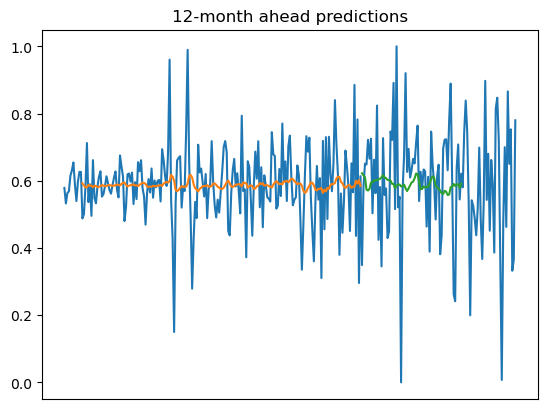

In [342]:
pred_train = ar_lstm_model.predict(X_train)#[:, :, 0]
pred_test = ar_lstm_model.predict(X_test)#[:, :, 0]

# un-scale the predictions
# price_ts = scaler.inverse_transform(price_ts)
# pred_train = scaler.inverse_transform(pred_train)
# pred_test = scaler.inverse_transform(pred_test)

plt.plot(price_d1_ts)
plt.gca().set_xticks([])

plt.plot(range(lookback, lookback + len(pred_train)), pred_train[:, -1])
plt.plot(
    range(lookback + len(pred_train),
          lookback + len(pred_train) + len(pred_test)), pred_test[:, -1])
plt.title('12-month ahead predictions')
plt.show()

In [343]:
pred_train.shape

(186, 12, 1)

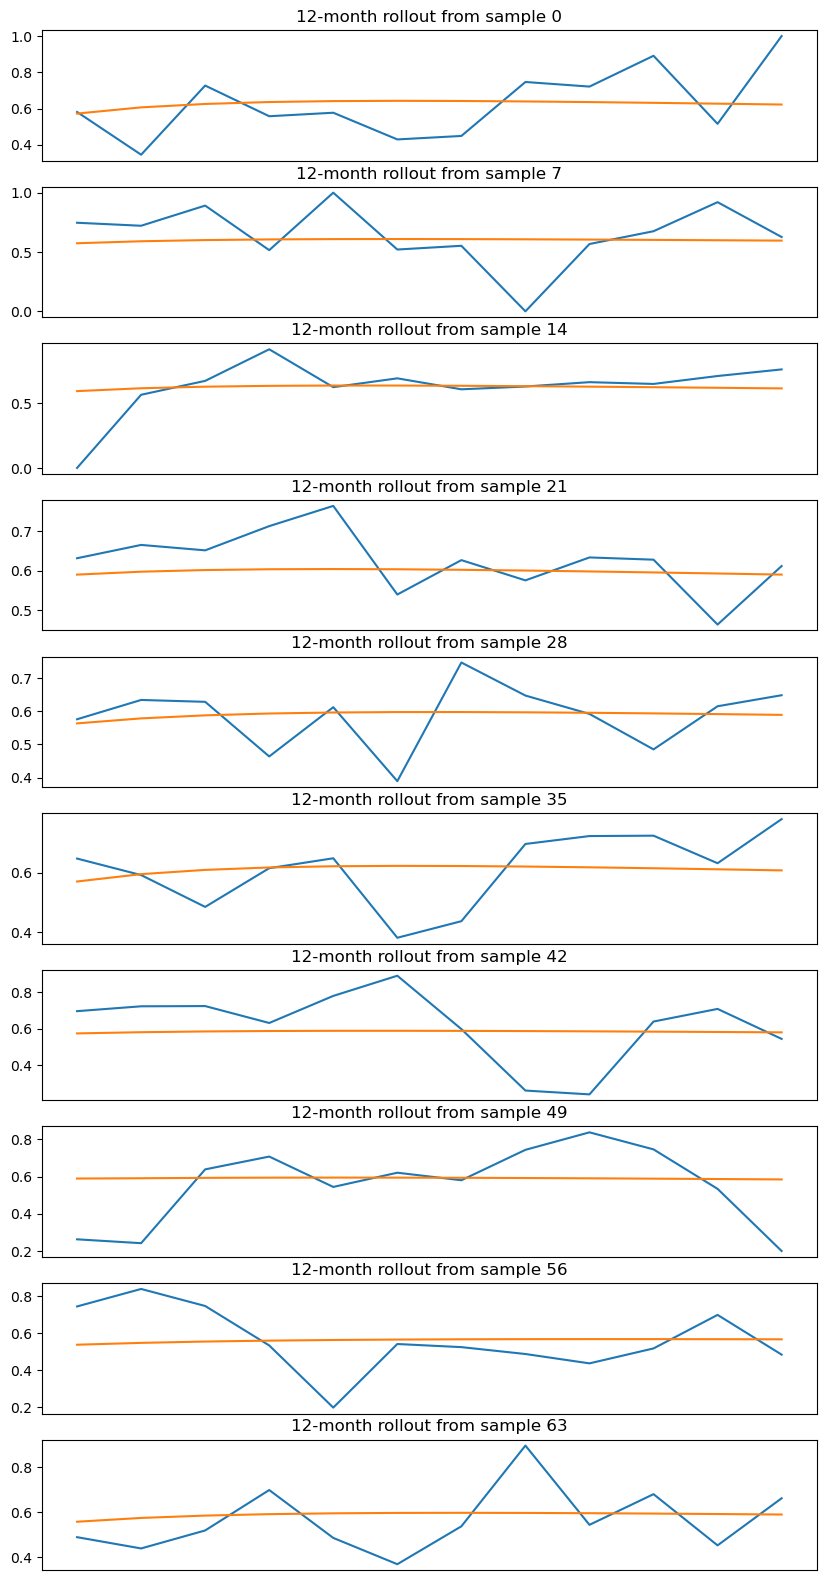

In [344]:
# rollout predictions
plt.figure(figsize=(10, 20))
for i in range(10):
    plt.subplot(10, 1, i+1)
    plt.gca().set_xticks([])
    plt.plot(X_test[i*7])
    plt.plot(pred_test[i*7])

    plt.title(f'12-month rollout from sample {i*7}')
plt.show()

damn so it's basically just predicting the average lol

In [345]:
# un-scale the predictions
price_d1_ts = scaler.inverse_transform(price_d1_ts)
pred_train = scaler.inverse_transform(pred_train[:, -1])
pred_test = scaler.inverse_transform(pred_test[:, -1])

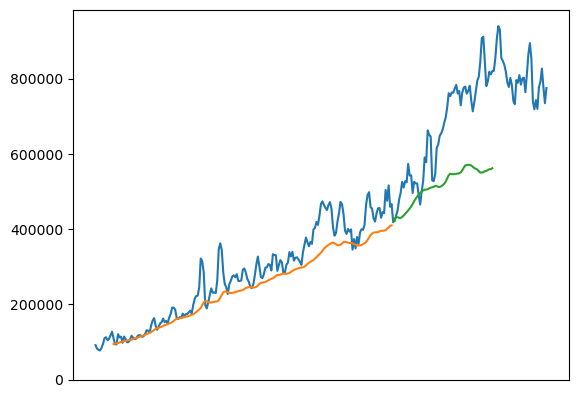

In [346]:
price_d1_ts_cum = np.cumsum(price_d1_ts) + area_data.average_price[0]
pred_train_cum = np.cumsum(pred_train) + area_data.average_price[0]
pred_test_cum = np.cumsum(pred_test) + pred_train_cum[-1]

plt.plot(price_d1_ts_cum)
plt.gca().set_xticks([])
# plt.plot(X_train[:, 0])
plt.plot(range(lookback, lookback + len(pred_train)), pred_train_cum)
plt.plot(
    range(lookback + len(pred_train),
          lookback + len(pred_train) + len(pred_test)), pred_test_cum)
plt.ylim(bottom=0)
plt.show()

### TODO: we need to predict further into the future + predict autoregressively